# ZNE calibration

In [1]:
import numpy as np
import json
from itertools import product
from matplotlib import pyplot as plt
from qiskit_ibm_runtime import RuntimeDecoder
from utils.plotting_styles import plt_styles
from utils.postprocessing import average_without_outliers, noise_amplification_factors
from warnings import filterwarnings
filterwarnings('ignore')

with open('data/N2_CS_noisy_energies.json', 'r') as infile:
    CS_noisy_energies = json.load(infile)
    seps_CS = np.array(CS_noisy_energies['bond_lengths'])
    FCI_reduced = np.array(CS_noisy_energies['FCI'])
with open('data/N2_dissociation_results.json', 'r') as infile:
    import json
    N2_PEC_data  = json.load(infile)
    seps_full    = np.array(N2_PEC_data['bond_lengths'])
    CS_noiseless = np.array(N2_PEC_data['energies']['CS-DD (5q)'])
    FCI          = np.array(N2_PEC_data['energies']['FCI'])
    
# takes ~30 seconds to load measurement data (On a Mac M2)
measurement_data = []
for PEC_index in range(10):
    print(f'Loading data for PEC index {PEC_index}')
    with open(f'data/raw_measurements/N2_vqe_results_{PEC_index}.txt', 'r') as f:
        decoder = RuntimeDecoder()
        data_in = decoder.decode(f.read())
        vqe_result = data_in['result']
        vqe_inputs = data_in['inputs']
        zne_degree = data_in['zne_degree']
        use_depth  = data_in['calibrate_by_depth']
        measurement_data.append((PEC_index, vqe_result, vqe_inputs, zne_degree, use_depth))

Loading data for PEC index 0
Loading data for PEC index 1
Loading data for PEC index 2
Loading data for PEC index 3
Loading data for PEC index 4
Loading data for PEC index 5
Loading data for PEC index 6
Loading data for PEC index 7
Loading data for PEC index 8
Loading data for PEC index 9


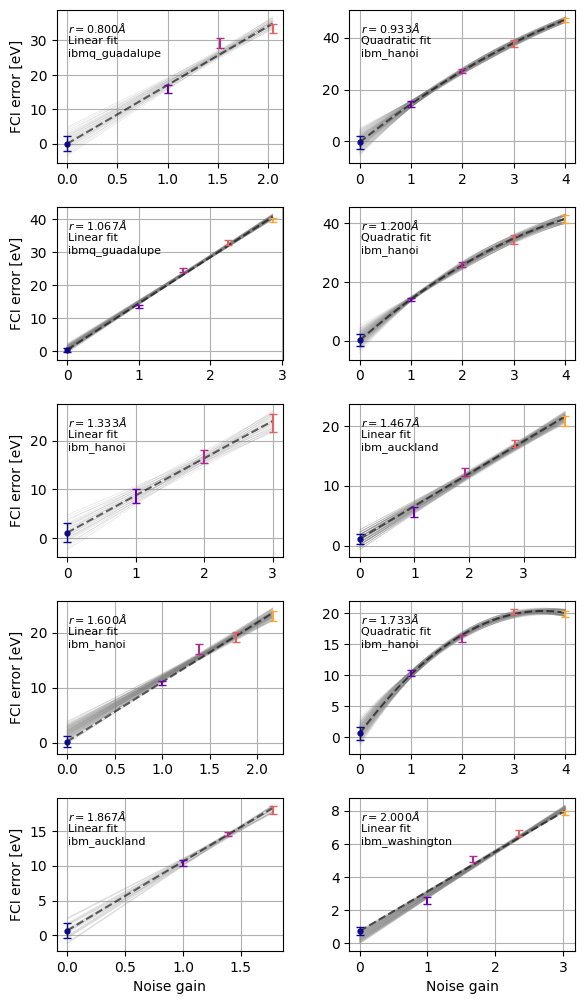

In [6]:
ev_unit = 27.2114
fig, axes = plt.subplots(5,2,figsize=(6,10), sharex=False, sharey=False)
fig.tight_layout()
final_energies = {'CS-5q':[],'bond_lengths':seps_CS.tolist(), 'FCI':FCI_reduced.tolist()}

for i, (PEC_index, vqe_result, vqe_inputs, deg, use_depth) in enumerate(measurement_data):
    qpu_name = vqe_result['VQE_spec']['hardware_spec']['backend_name']
    n_clusters = vqe_result['VQE_spec']['hardware_spec']['n_qubits']//5
    params = list(vqe_result['VQE_data']['parameter_history'].values())
    X_grad, Y_grad = zip(*vqe_result['VQE_data']['gradient_history']['values'].items())
    Y_grad_norm = np.linalg.norm(Y_grad, axis=1)
    conv_mask = Y_grad_norm<np.sqrt(Y_grad_norm.min())
    conv_ind = np.where(conv_mask)[0][0]
    X_energy, Y_energy = zip(*vqe_result['VQE_data']['energy_history']['values'].items())
    Y_energy = np.array([
        vqe_result['VQE_data']['energy_history']['data'][str(i)]['data_for_extrapolation']
        for i in X_energy
    ])
    conv_mask = np.append(conv_mask, np.ones(Y_energy.shape[0]-conv_mask.shape[0], dtype=bool))
    Y_energy, Y_std = zip(*average_without_outliers(Y_energy[conv_mask].T))
    Y_energy, Y_std = np.array(Y_energy), np.array(Y_std)
    nf = noise_amplification_factors(vqe_result, use_depth=use_depth)
    weights = 1/Y_std
    fit_params = np.polyfit(nf, Y_energy, deg=deg, w=weights)
    fit_func = np.poly1d(fit_params)
    zne_val = fit_params[-1]
    zne_fits = [np.poly1d(np.polyfit(nf, y, deg=deg))
        for y in Y_energy + Y_std * np.array(list(product([-1,0,+1], repeat=len(nf))))]
    zne_std = np.std([f(0) for f in zne_fits]) 

    ##################################
    ## PLOT THE NOISE EXTRAPOLATION ##
    ##################################
    row,col=int(i//2),int(i%2)
    loc_in_full = np.argmin(abs(seps_full - seps_CS[i]))
    _nf = np.linspace(0,nf[-1])
    for f in zne_fits:
        axes[row,col].plot(_nf, (f(_nf)-FCI_reduced[i])*ev_unit,color='grey',ls='-',alpha=0.2,lw=0.5)
    for _i,_y in enumerate(Y_energy):
        axes[row,col].errorbar(
            nf[_i], [(_y-FCI_reduced[i])*ev_unit], yerr=[Y_std[_i]*ev_unit],
            marker='',ls='',capsize=3,ms=4,color=plt.cm.plasma((_i+1)/5),zorder=100
        )
    axes[row,col].errorbar(
        [0], [(zne_val-FCI_reduced[i])*ev_unit], 
        yerr=[zne_std*ev_unit], **plt_styles['CS']
    )
    axes[row,col].plot(_nf, (fit_func(_nf)-FCI_reduced[i])*ev_unit,color='black',alpha=0.6,ls='--')
    axes[row,col].grid()
    final_energies['CS-5q'].append((zne_val, zne_std/np.sqrt(n_clusters))) # standard error
    if deg==1:fitstr='Linear'
    if deg==2:fitstr='Quadratic'
    axes[row,col].text(0.05,0.7,f'$r={seps_CS[i]:.3f}\\AA$\n{fitstr} fit\n{qpu_name}', transform=axes[row,col].transAxes,fontsize=8)
    
    if col == 0:
        axes[row,col].set_ylabel('FCI error [eV]')
    if row == 4:
        axes[row,col].set_xlabel('Noise gain')

fig.savefig(f'plots/N2_ZNE_fitting.png', dpi=300, bbox_inches='tight', transparent=True)

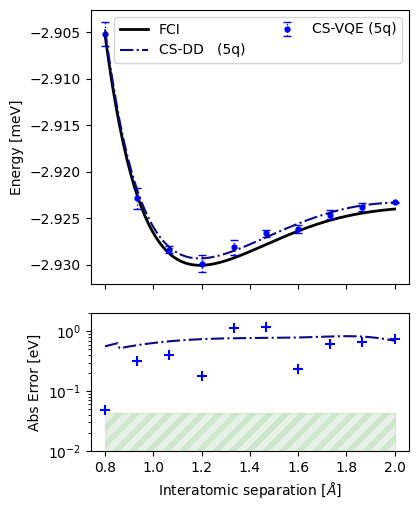

In [7]:
#plt.style.use('ggplot')
plt.rc('hatch', color='k', linewidth=4)

ev_unit = 27.2114

CS_val,CS_std = zip(*final_energies['CS-5q'])
CS_val,CS_std = np.array(CS_val),np.array(CS_std)

fig, axes = plt.subplots(2,1,figsize=(4,5),gridspec_kw={'height_ratios':(2,1)}, sharex=True)
fig.tight_layout()

axes[0].plot(seps_full, (FCI*ev_unit)/1e3,  label='FCI',  lw=2, ls='-',  color='black')
eb = axes[0].errorbar(
    seps_CS, (CS_val*ev_unit)/1e3, yerr=CS_std*ev_unit/1e3, 
    marker='.',capsize=3, ls='', ms=7, color='blue', lw=1,
    zorder=10, label='CS-VQE (5q)',
)
eb[-1][0].set_linestyle(':')

axes[1].fill_between(seps_full, 0, 0.0016*ev_unit,
    color='green', alpha=0.1, label='$10\%$ error',hatch=r"//", 
)
axes[0].plot(seps_full, CS_noiseless*ev_unit/1e3, color=plt_styles['CS']['color'], zorder=1000, label='CS-DD   (5q)', ls='-.')
axes[1].plot(seps_full, (CS_noiseless-FCI)*ev_unit, color=plt_styles['CS']['color'], zorder=1000, ls='-.')

axes[1].scatter(seps_CS, abs(CS_val-FCI_reduced)*ev_unit, marker='+', color='blue', s=50, zorder=10, label='CS-VQE')
axes[1].set_ylim([0.01,2])
axes[1].set_yscale('log')
axes[0].set_ylabel('Energy [meV]')
axes[1].set_ylabel('Abs Error [eV]')
axes[1].set_xlabel('Interatomic separation [$\AA$]')
axes[0].legend(ncol=2)

In [12]:
# with open('data/N2_CS_noisy_energies.json', 'w') as outfile:
#     json.dump({a:b for a,b in final_energies.items()}, outfile)